# Milk analysis

## import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

## Check data

In [4]:
df = pd.read_csv("./milknew.csv")
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [3]:
df.isnull().any()

pH            False
Temprature    False
Taste         False
Odor          False
Fat           False
Turbidity     False
Colour        False
Grade         False
dtype: bool

## Plot all

In [4]:
## sns.pairplot(data=df, hue="Grade")

In [5]:
df_original = df.copy(deep=True)

dum = pd.get_dummies(df['Grade'])
df.drop(['Grade'], axis=1, inplace=True)
df = pd.concat([df, dum], axis=1)

## Heatmap

<AxesSubplot:>

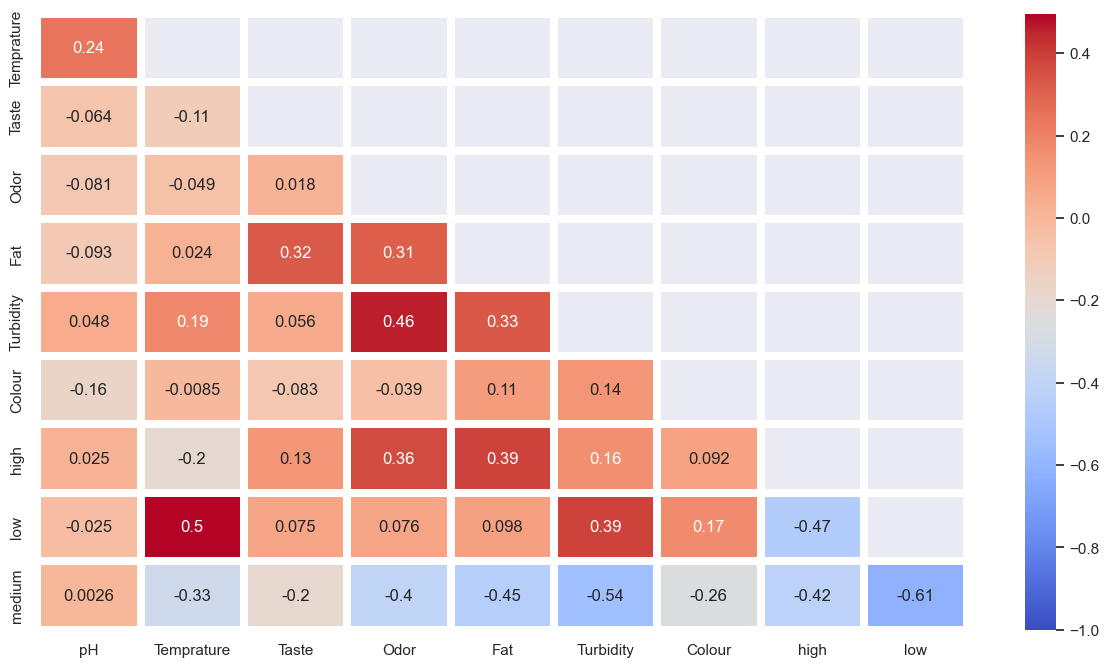

In [6]:
df_corr = df.corr()

# mask
mask = np.triu(np.ones_like(df_corr, dtype=bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:, :-1].copy()

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, linewidths=5.5, cmap="coolwarm")


fat is highly correlated to the grade of the milk

the same can be said for turbidity of the milk in relations to the grade

The ph seems to have little effect on the grade

Taste has a small correlation to the grade of the milk

<AxesSubplot:>

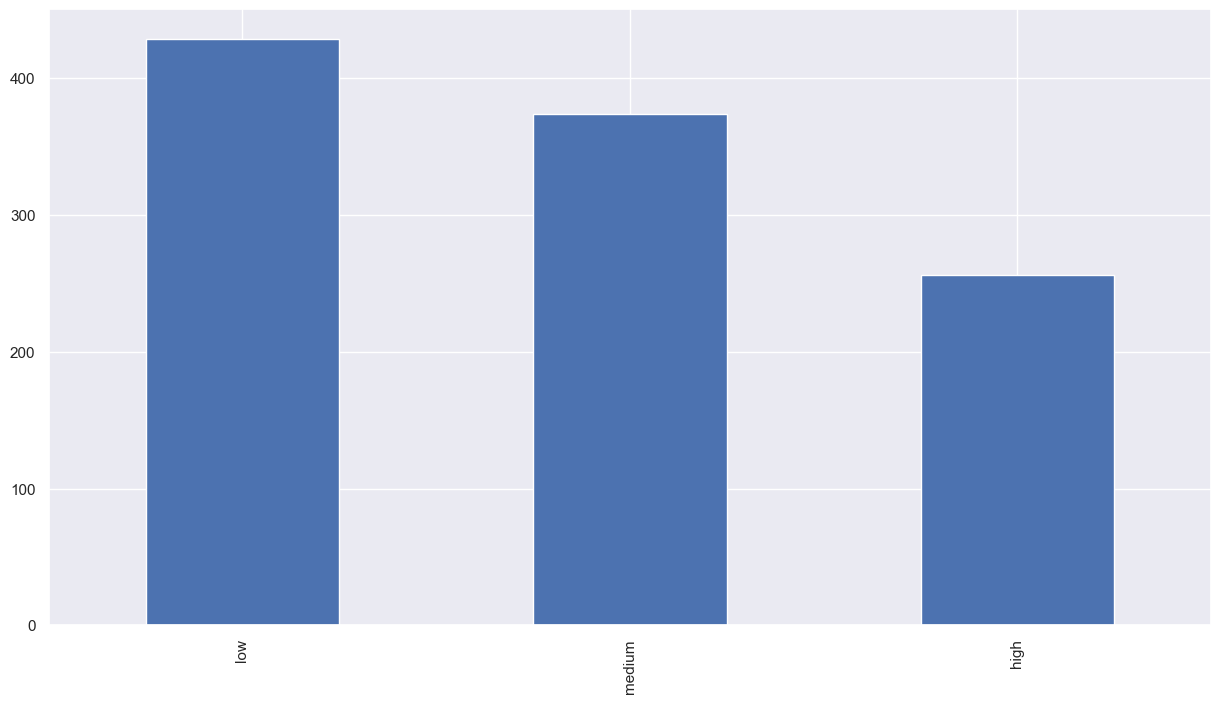

In [7]:
freq = df_original['Grade'].value_counts()
freq.plot(kind='bar')

In [8]:
Fat_con_table = df_original.groupby(['Grade', 'Fat']).size().unstack('Fat')
Fat_con_table

Fat,0,1
Grade,,
high,1,255
low,117,312
medium,230,144


In [9]:
from scipy.stats import chi2_contingency
chi2_contingency(Fat_con_table)

(267.4203186732531,
 8.519529787197151e-59,
 2,
 array([[ 84.12464589, 171.87535411],
        [140.97450425, 288.02549575],
        [122.90084986, 251.09915014]]))

In [10]:
Turbidity_con_table = df_original.groupby(['Grade', 'Turbidity']).size().unstack('Turbidity')
Turbidity_con_table

Turbidity,0,1
Grade,,
high,94,162
low,118,311
medium,327,47


In [11]:
chi2_contingency(Turbidity_con_table)

(314.2759507488154,
 5.699600257861163e-69,
 2,
 array([[130.29650614, 125.70349386],
        [218.34844193, 210.65155807],
        [190.35505194, 183.64494806]]))

The value of 8.5*10^-59 (P-value) suggests that Fat has a high influence on the Grade of the milk

The value of 5.6*10^-69 (P-value) suggests that Turbidity has a high influence on the Grade of the milk

<AxesSubplot:xlabel='Grade', ylabel='Fat'>

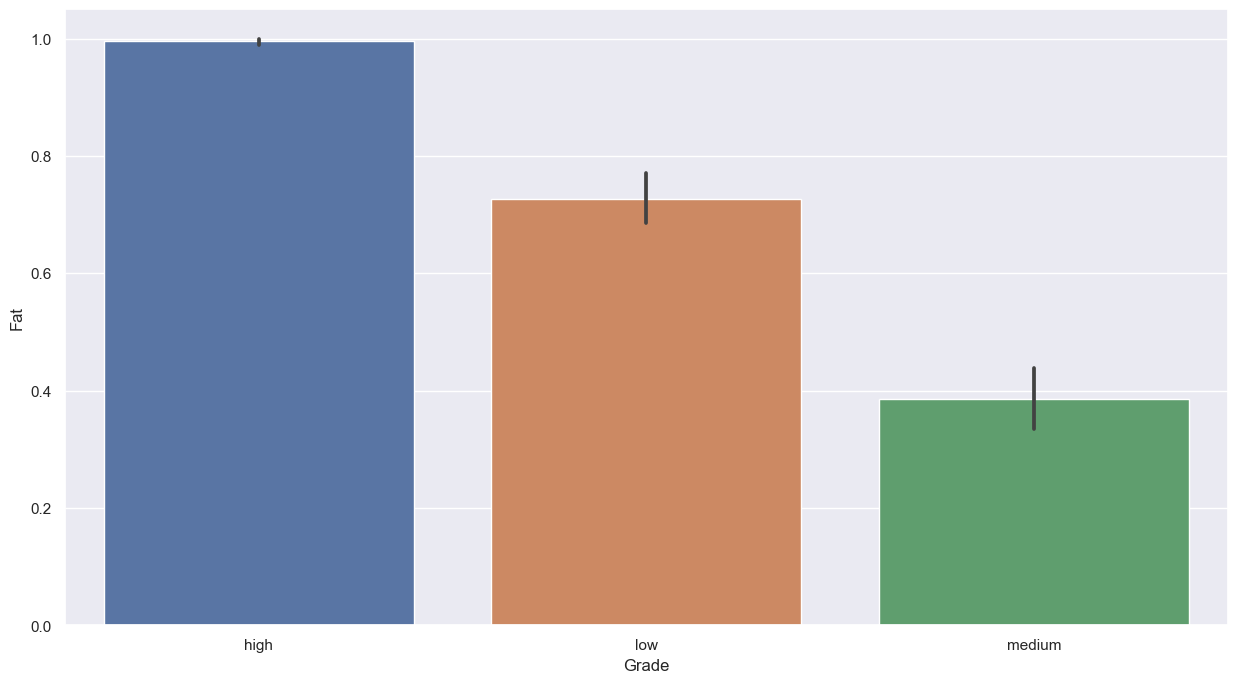

In [12]:
fat_grade = df_original[['Fat', 'Grade']]
sns.barplot(y="Fat", x="Grade", data=fat_grade)

<AxesSubplot:xlabel='Grade', ylabel='Turbidity'>

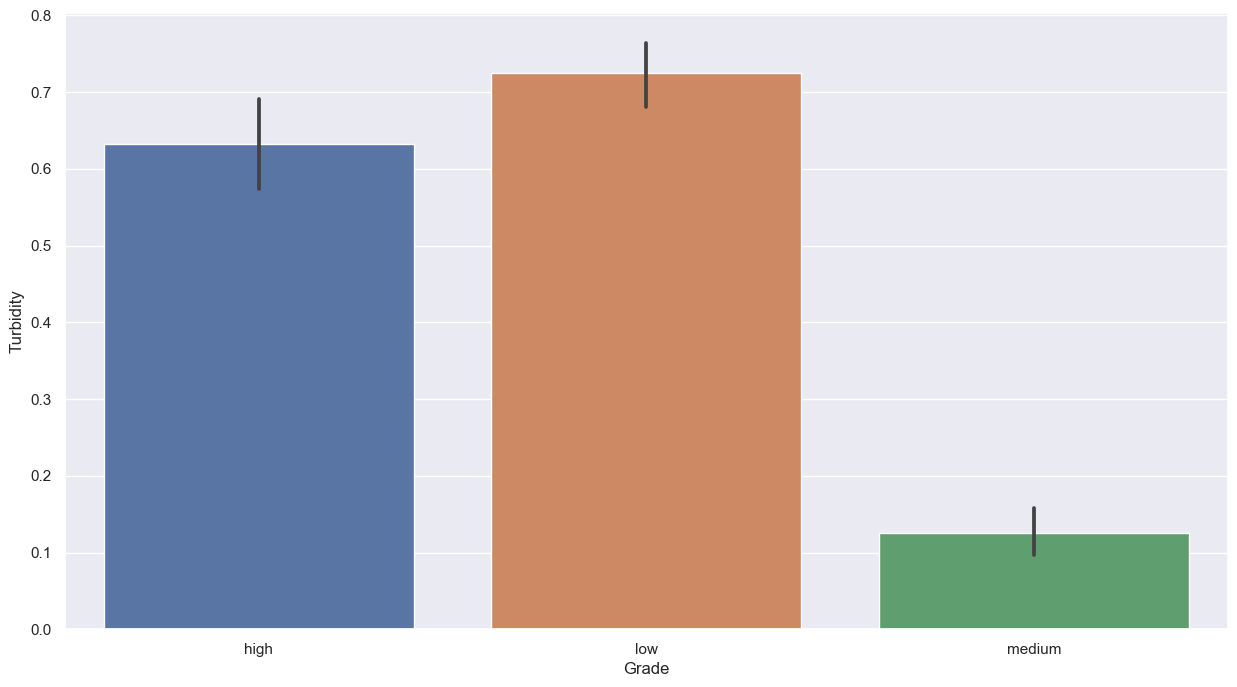

In [13]:
turbidity_grade = df_original[['Turbidity', 'Grade']]
sns.barplot(y="Turbidity", x="Grade", data=turbidity_grade)

# Prediction

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [12]:
df_original['Grade'] = pd.factorize(df_original['Grade'])[0]

X = df_original.copy()
y = X.pop('Grade')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
print(X_train.shape, X_test.shape)

df_original.head()
X_test.head()

(794, 7) (265, 7)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
384,6.6,45,0,0,0,1,250
288,5.6,50,0,1,1,1,255
221,6.8,45,0,1,1,1,255
769,3.0,40,1,1,1,1,255
205,6.6,37,1,1,1,1,255


## DecisionTree

In [33]:
featuresModel1 = ['Fat', 'Turbidity',
                  'Temprature', 'Taste', 'pH', 'Colour', 'Odor']
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
predictions = dt.predict(X_test) 
predictions2 = dt.predict([[6.8, 45, 0, 1, 1, 1, 255]])
print(predictions[:5])
print(predictions2[:1])
X_test.head()

[2 1 0 1 0]
[0]


C:\Users\jelle\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
384,6.6,45,0,0,0,1,250
288,5.6,50,0,1,1,1,255
221,6.8,45,0,1,1,1,255
769,3.0,40,1,1,1,1,255
205,6.6,37,1,1,1,1,255


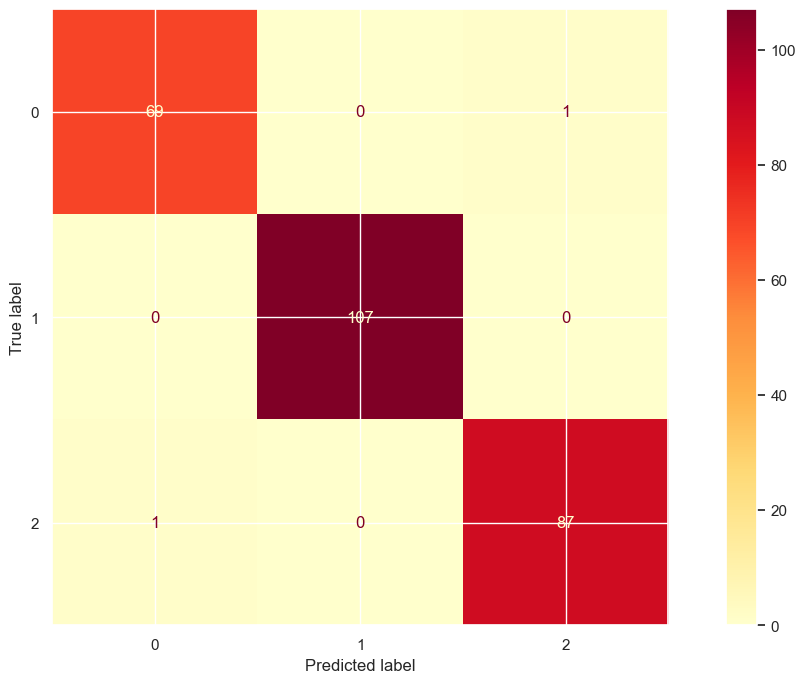

In [18]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap='YlOrRd')

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        70
           1       1.00      1.00      1.00       107
           2       0.99      0.99      0.99        88

    accuracy                           0.99       265
   macro avg       0.99      0.99      0.99       265
weighted avg       0.99      0.99      0.99       265



In [20]:
from sklearn.metrics import accuracy_score
 
decisionTreeAccuracy = accuracy_score(y_test, predictions)    
print(decisionTreeAccuracy)

0.9924528301886792


## Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, random_state=123)
forest.fit(X_train, y_train)

predictions_two = forest.predict(X_test)
print(predictions_two[:5])

[2 1 0 1 0]


In [22]:
forestAccuracy = accuracy_score(y_test, predictions_two)
print(forestAccuracy)

1.0


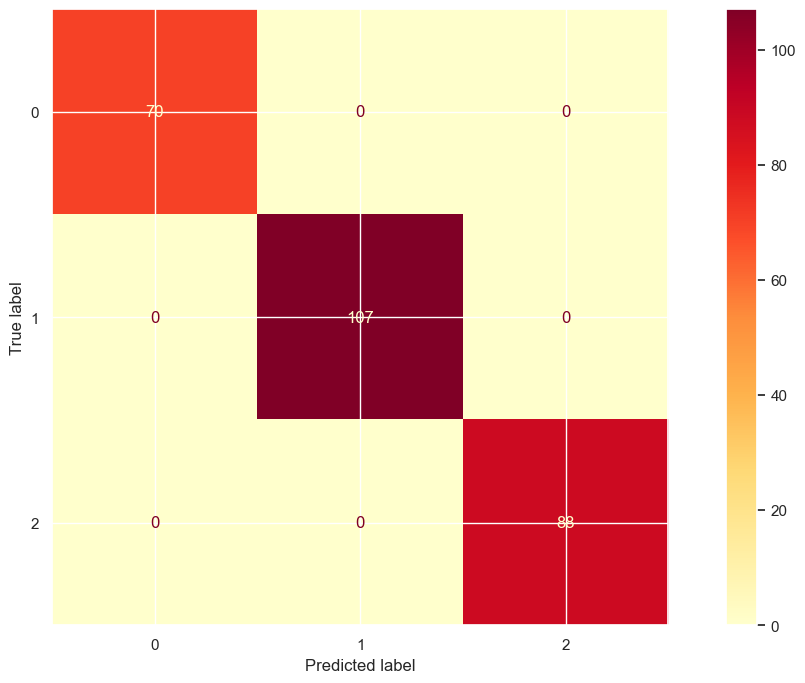

In [23]:
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, cmap='YlOrRd')

In [24]:
print(classification_report(y_test, predictions_two))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00        88

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265



Feature ranking:
1. feature 0 Fat (0.400910)
2. feature 1 Turbidity (0.218941)
3. feature 5 Temprature (0.098680)
4. feature 4 Taste (0.093930)
5. feature 6 pH (0.071647)
6. feature 3 Colour (0.068218)
7. feature 2 Odor (0.047674)


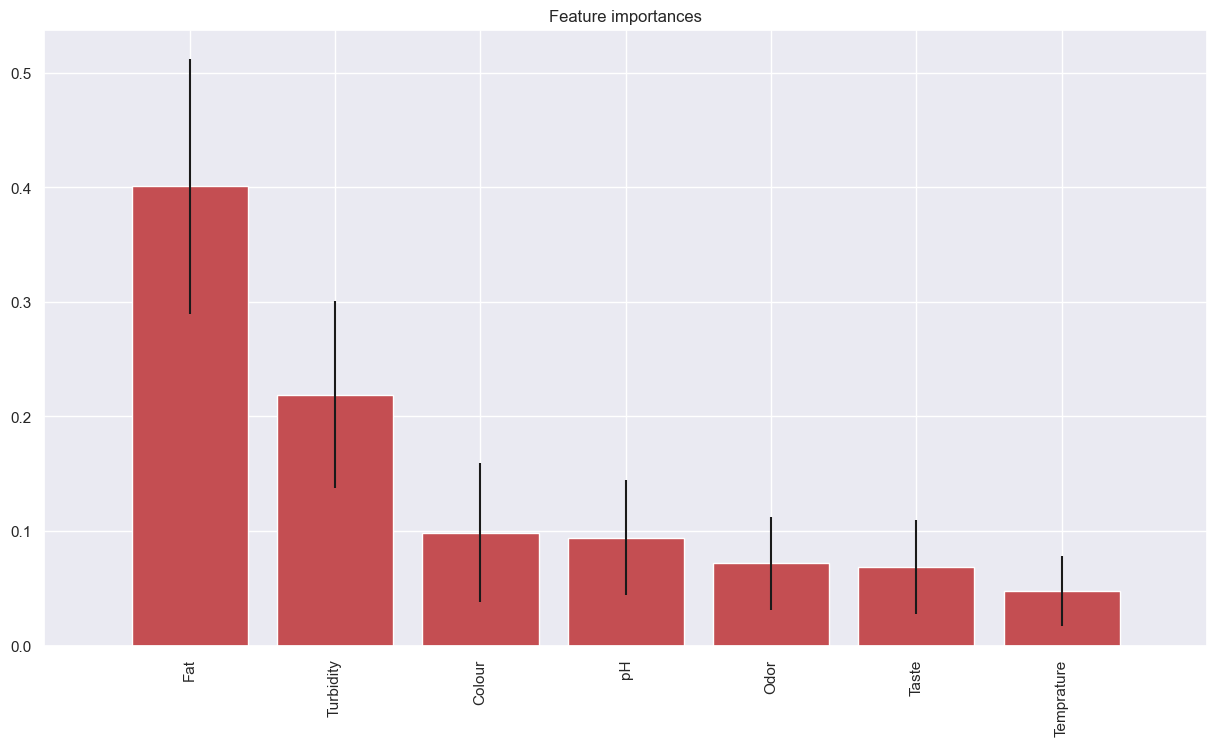

In [25]:
features = ['Fat', 'Turbidity',
            'Temprature', 'Taste', 'pH', 'Colour', 'Odor']

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = pd.Series(features)

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features)):
    print("%d. feature %d %s (%f)" %
          (f + 1, indices[f], features[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.xlim([-1, len(features)])
plt.show()

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [27]:
xLR = df_original.drop(columns='Grade')
yLR = df_original['Grade']

In [28]:
scaler = MinMaxScaler()

In [29]:
xLR = scaler.fit_transform(xLR)

In [30]:
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(xLR, yLR, random_state=100)

In [31]:
lgr = LogisticRegression()

In [32]:
lgr.fit(X_train_LR, y_train_LR)

LogisticRegression()

In [33]:
LogisticRegression()

LogisticRegression()

In [34]:
y_pred = lgr.predict(X_test_LR)

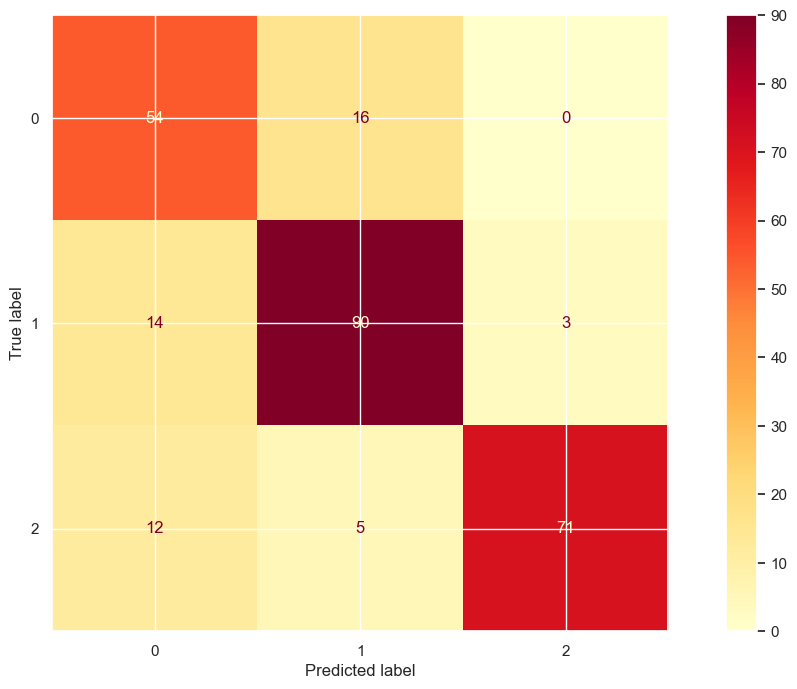

In [35]:
ConfusionMatrixDisplay.from_estimator(lgr, X_test_LR, y_test_LR, cmap='YlOrRd')

In [36]:
print(classification_report(y_test_LR, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72        70
           1       0.81      0.84      0.83       107
           2       0.96      0.81      0.88        88

    accuracy                           0.81       265
   macro avg       0.82      0.81      0.81       265
weighted avg       0.82      0.81      0.81       265



In [37]:
logisticRegressionAccuracy = accuracy_score(y_test_LR,y_pred)
print(logisticRegressionAccuracy)

0.8113207547169812


## Artificial neural network

In [38]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [39]:
X = df.copy()
X = X.drop(['low', 'medium', 'high'], axis=1)
y = df.copy()
y = y.drop(['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
print(X_train.shape, X_test.shape)

(794, 7) (265, 7)


In [40]:
X.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
0,6.6,35,1,0,1,0,254
1,6.6,36,0,1,0,1,253
2,8.5,70,1,1,1,1,246
3,9.5,34,1,1,0,1,255
4,6.6,37,0,0,0,0,255


### NN zonder Hidden layers

In [41]:
model = Sequential()
model.add(Dense(3, input_shape=(7,), activation='softmax'))
model.compile(Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.fit(X_train, y_train, epochs=100, shuffle=True, validation_split=0.1)
accTwo = model.history.history['accuracy']

Epoch 1/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.7227 - val_loss: 0.5360 - val_accuracy: 0.7875
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.7185 - val_loss: 0.5663 - val_accuracy: 0.7250
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.6891 - val_loss: 0.6492 - val_accuracy: 0.7625
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.7045 - val_loss: 0.5301 - val_accuracy: 0.7625
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.7213 - val_loss: 0.4601 - val_accuracy: 0.7625
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5886 - accuracy: 0.7283 - val_loss: 0.4702 - val_accuracy: 0.7875
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.7059 - val_loss: 0.4650 - val_accuracy: 0.7625
Epoch 8/100
2

Epoch 59/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6255 - accuracy: 0.7157 - val_loss: 0.4539 - val_accuracy: 0.7875
Epoch 60/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.7045 - val_loss: 0.5498 - val_accuracy: 0.7375
Epoch 61/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5917 - accuracy: 0.7241 - val_loss: 0.4530 - val_accuracy: 0.7875
Epoch 62/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.7311 - val_loss: 0.4869 - val_accuracy: 0.7875
Epoch 63/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.7339 - val_loss: 0.5517 - val_accuracy: 0.8000
Epoch 64/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6036 - accuracy: 0.7101 - val_loss: 0.5061 - val_accuracy: 0.7875
Epoch 65/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6013 - accuracy: 0.7115 - val_loss: 0.6428 - val_accuracy: 0.7250
Epoch 

### NN met Hidden layers

In [44]:
## Met andere inputs! (Features eruit gedaan zoals: Taste en Colour)
X_WH = df.copy()
X_WH = X_WH.drop(['low', 'medium', 'high', 'Taste', 'Colour'], axis=1)
y_WH = df.copy()
y_WH = y_WH.drop(['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour'], axis=1)

X_train_WH, X_test_WH, y_train_WH, y_test_WH = train_test_split(X_WH, y_WH, random_state=100)
print(X_train.shape, X_test.shape)

(794, 7) (265, 7)


In [45]:
modelTwo = Sequential()
modelTwo.add(Dense(20, input_shape=(5,), activation='tanh'))
modelTwo.add(Dense(3, activation='softmax'))


modelTwo.compile(Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/200
23/23 [==============================] - 1s 17ms/step - loss: 1.3976 - accuracy: 0.4426 - val_loss: 1.0667 - val_accuracy: 0.5000
Epoch 2/200
23/23 [==============================] - 0s 6ms/step - loss: 0.9895 - accuracy: 0.5854 - val_loss: 0.9347 - val_accuracy: 0.6375
Epoch 3/200
23/23 [==============================] - 0s 5ms/step - loss: 0.8869 - accuracy: 0.5882 - val_loss: 0.8425 - val_accuracy: 0.6750
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.8330 - accuracy: 0.6036 - val_loss: 0.7833 - val_accuracy: 0.7375
Epoch 5/200
23/23 [==============================] - 0s 5ms/step - loss: 0.7852 - accuracy: 0.7227 - val_loss: 0.7417 - val_accuracy: 0.7750
Epoch 6/200
23/23 [==============================] - 0s 6ms/step - loss: 0.7272 - accuracy: 0.7451 - val_loss: 0.6834 - val_accuracy: 0.7875
Epoch 7/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6774 - accuracy: 0.7269 - val_loss: 0.6394 - val_accuracy: 0.6875
Epoch 8/200


Epoch 59/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2641 - accuracy: 0.8866 - val_loss: 0.3473 - val_accuracy: 0.8625
Epoch 60/200
23/23 [==============================] - 0s 7ms/step - loss: 0.2780 - accuracy: 0.8697 - val_loss: 0.2748 - val_accuracy: 0.9125
Epoch 61/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2518 - accuracy: 0.8992 - val_loss: 0.2877 - val_accuracy: 0.8625
Epoch 62/200
23/23 [==============================] - 0s 5ms/step - loss: 0.2518 - accuracy: 0.8908 - val_loss: 0.2877 - val_accuracy: 0.9125
Epoch 63/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2581 - accuracy: 0.8908 - val_loss: 0.2694 - val_accuracy: 0.9125
Epoch 64/200
23/23 [==============================] - 0s 5ms/step - loss: 0.2772 - accuracy: 0.8894 - val_loss: 0.2998 - val_accuracy: 0.8625
Epoch 65/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2517 - accuracy: 0.9048 - val_loss: 0.2566 - val_accuracy: 0.9125
Epoch 

23/23 [==============================] - 0s 7ms/step - loss: 0.1790 - accuracy: 0.9202 - val_loss: 0.1773 - val_accuracy: 0.9125
Epoch 174/200
23/23 [==============================] - 0s 5ms/step - loss: 0.1876 - accuracy: 0.9160 - val_loss: 0.1958 - val_accuracy: 0.9125
Epoch 175/200
23/23 [==============================] - 0s 8ms/step - loss: 0.1847 - accuracy: 0.9132 - val_loss: 0.1720 - val_accuracy: 0.9125
Epoch 176/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1810 - accuracy: 0.9244 - val_loss: 0.1833 - val_accuracy: 0.9125
Epoch 177/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1759 - accuracy: 0.9188 - val_loss: 0.1668 - val_accuracy: 0.9125
Epoch 178/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1701 - accuracy: 0.9188 - val_loss: 0.1740 - val_accuracy: 0.9125
Epoch 179/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1731 - accuracy: 0.9160 - val_loss: 0.1718 - val_accuracy: 0.9125
Epoch 180/200

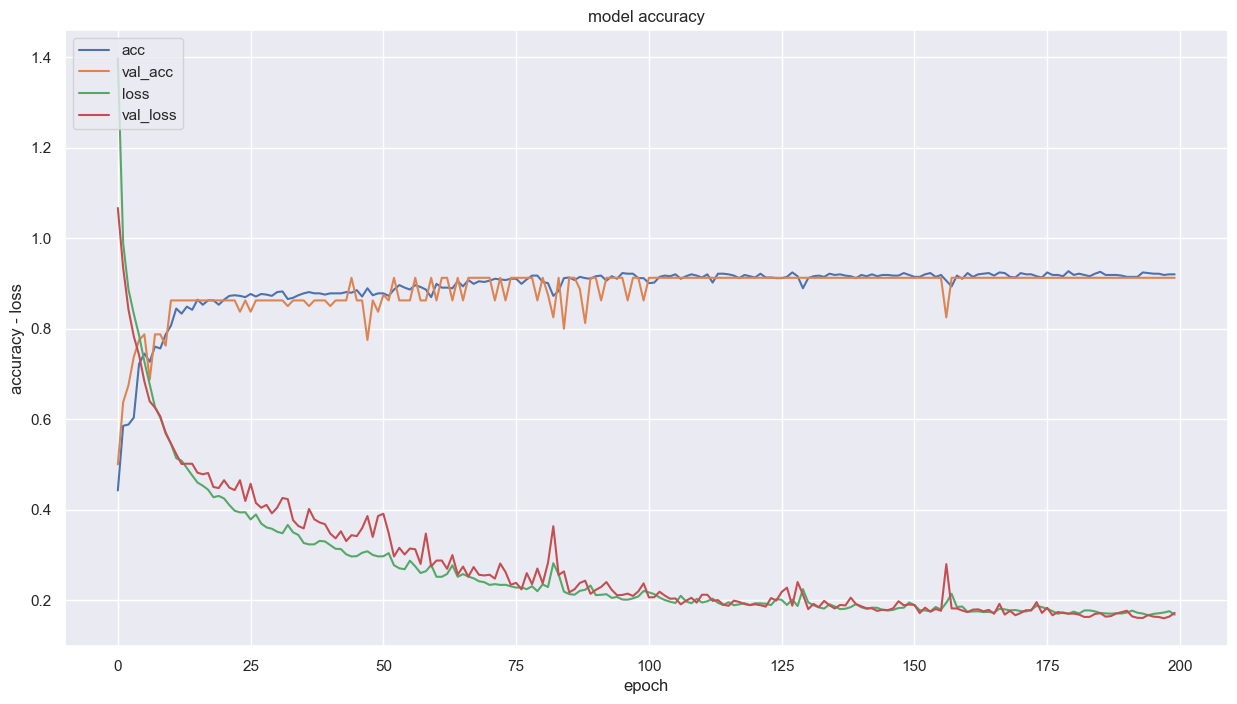

In [46]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

modelTwo.fit(X_train_WH, y_train_WH, epochs=200, shuffle=True,
          validation_split=0.1)

acc = modelTwo.history.history['accuracy']
val_acc = modelTwo.history.history['val_accuracy']
loss = modelTwo.history.history['loss']
val_loss = modelTwo.history.history['val_loss']

epochs = range(1, len(acc) + 1)

# sns.lineplot(x=epochs, y=acc, palette='tab10', linewidth=2.5)

plt.plot(acc)
plt.plot(val_acc)
plt.plot(loss)
plt.plot(val_loss)
plt.title('model accuracy')
plt.ylabel('accuracy - loss')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='upper left')
plt.show()

<hr />

In [47]:
modelThree = Sequential()
modelThree.add(Dense(20, input_shape=(5,), activation='tanh'))
modelThree.add(Dense(3, activation='softmax'))

## Lagere learning rate
modelThree.compile(Adam(learning_rate=0.003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/250
23/23 [==============================] - 1s 21ms/step - loss: 1.1416 - accuracy: 0.3445 - val_loss: 1.0744 - val_accuracy: 0.4000
Epoch 2/250
23/23 [==============================] - 0s 6ms/step - loss: 1.0702 - accuracy: 0.4398 - val_loss: 1.0143 - val_accuracy: 0.6750
Epoch 3/250
23/23 [==============================] - 0s 7ms/step - loss: 0.9966 - accuracy: 0.5602 - val_loss: 0.9428 - val_accuracy: 0.6375
Epoch 4/250
23/23 [==============================] - 0s 6ms/step - loss: 0.9465 - accuracy: 0.5882 - val_loss: 0.8873 - val_accuracy: 0.6750
Epoch 5/250
23/23 [==============================] - 0s 6ms/step - loss: 0.9110 - accuracy: 0.6078 - val_loss: 0.8648 - val_accuracy: 0.6375
Epoch 6/250
23/23 [==============================] - 0s 6ms/step - loss: 0.8816 - accuracy: 0.5938 - val_loss: 0.8189 - val_accuracy: 0.6625
Epoch 7/250
23/23 [==============================] - 0s 6ms/step - loss: 0.8435 - accuracy: 0.6275 - val_loss: 0.7915 - val_accuracy: 0.6500
Epoch 8/250


Epoch 59/250
23/23 [==============================] - 0s 6ms/step - loss: 0.3692 - accuracy: 0.8711 - val_loss: 0.3892 - val_accuracy: 0.8375
Epoch 60/250
23/23 [==============================] - 0s 5ms/step - loss: 0.3754 - accuracy: 0.8515 - val_loss: 0.3831 - val_accuracy: 0.8625
Epoch 61/250
23/23 [==============================] - 0s 5ms/step - loss: 0.3739 - accuracy: 0.8697 - val_loss: 0.3868 - val_accuracy: 0.9125
Epoch 62/250
23/23 [==============================] - 0s 5ms/step - loss: 0.3548 - accuracy: 0.8739 - val_loss: 0.3773 - val_accuracy: 0.8625
Epoch 63/250
23/23 [==============================] - 0s 7ms/step - loss: 0.3544 - accuracy: 0.8711 - val_loss: 0.3684 - val_accuracy: 0.8625
Epoch 64/250
23/23 [==============================] - 0s 4ms/step - loss: 0.3507 - accuracy: 0.8768 - val_loss: 0.3962 - val_accuracy: 0.8375
Epoch 65/250
23/23 [==============================] - 0s 6ms/step - loss: 0.3696 - accuracy: 0.8641 - val_loss: 0.3928 - val_accuracy: 0.8125
Epoch 

23/23 [==============================] - 0s 6ms/step - loss: 0.2017 - accuracy: 0.9118 - val_loss: 0.2028 - val_accuracy: 0.9125
Epoch 174/250
23/23 [==============================] - 0s 5ms/step - loss: 0.2003 - accuracy: 0.9174 - val_loss: 0.2022 - val_accuracy: 0.8875
Epoch 175/250
23/23 [==============================] - 0s 5ms/step - loss: 0.1956 - accuracy: 0.9174 - val_loss: 0.2035 - val_accuracy: 0.9125
Epoch 176/250
23/23 [==============================] - 0s 5ms/step - loss: 0.1962 - accuracy: 0.9188 - val_loss: 0.1993 - val_accuracy: 0.9125
Epoch 177/250
23/23 [==============================] - 0s 6ms/step - loss: 0.2024 - accuracy: 0.9146 - val_loss: 0.2015 - val_accuracy: 0.9125
Epoch 178/250
23/23 [==============================] - 0s 5ms/step - loss: 0.1965 - accuracy: 0.9174 - val_loss: 0.2039 - val_accuracy: 0.9125
Epoch 179/250
23/23 [==============================] - 0s 5ms/step - loss: 0.1977 - accuracy: 0.9160 - val_loss: 0.2047 - val_accuracy: 0.9125
Epoch 180/250

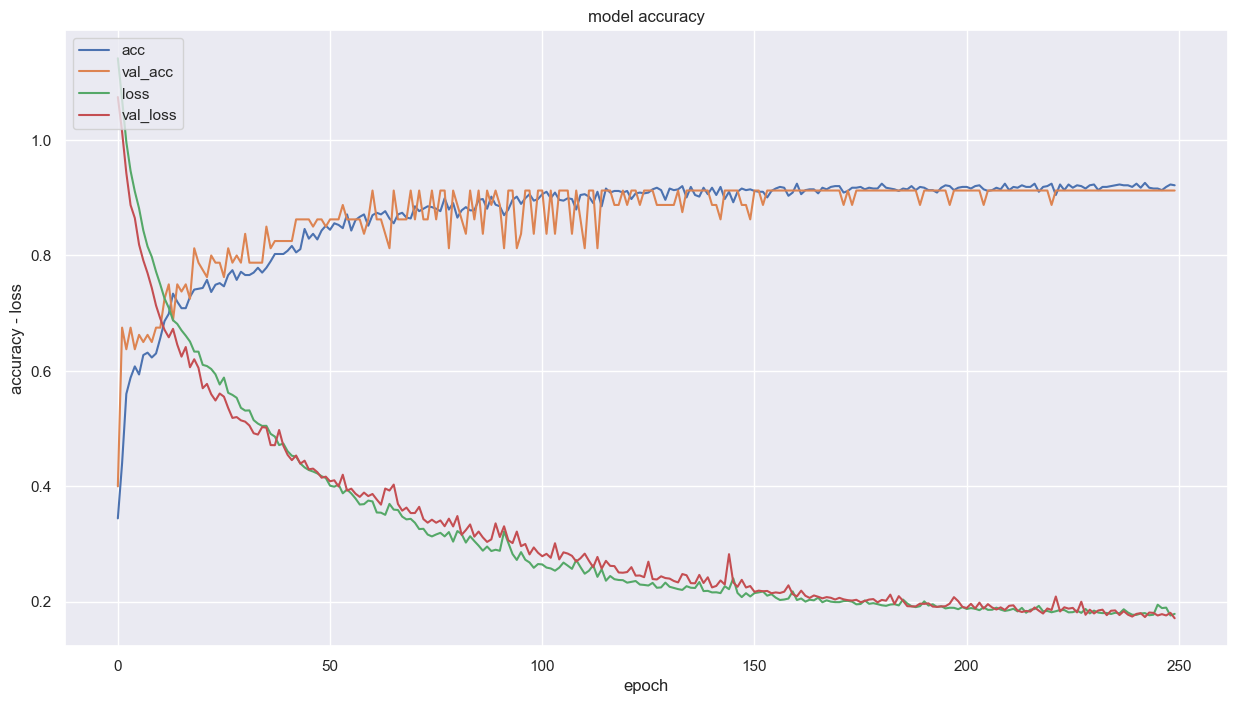

In [48]:
## Meer epochs
modelThree.fit(X_train_WH, y_train_WH, epochs=250, shuffle=True,
          validation_split=0.1)

acc = modelThree.history.history['accuracy']
val_acc = modelThree.history.history['val_accuracy']
loss = modelThree.history.history['loss']
val_loss = modelThree.history.history['val_loss']

epochs = range(1, len(acc) + 1)

# sns.lineplot(x=epochs, y=acc, palette='tab10', linewidth=2.5)

plt.plot(acc)
plt.plot(val_acc)
plt.plot(loss)
plt.plot(val_loss)
plt.title('model accuracy')
plt.ylabel('accuracy - loss')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='upper left')
plt.show()

# Benchmark results

In [49]:
model_performance_accuracy = pd.DataFrame({'Model': ['DecisionTreeClassifier', 'RandomForestClassifier',
                                                    'LogisticRegression', 'Neural Network met HL', 'Neural Network zonder HL'], 'Accuracy': [decisionTreeAccuracy, forestAccuracy, logisticRegressionAccuracy, acc[-1], accTwo[-1]]})

In [50]:
model_performance_accuracy.sort_values(by= 'Accuracy', ascending = False)

,Model,Accuracy
1,RandomForestClassifier,1.000000
0,DecisionTreeClassifier,0.992453
3,Neural Network met HL,0.921569
2,LogisticRegression,0.811321
4,Neural Network zonder HL,0.722689
